# Imports

## tf

In [2]:
from glob import glob
import os
from pathlib import Path
import random as rn
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.compat.v1.keras import backend as K
from tensorflow.keras.layers import Input, Dense
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
import yaml

from deepface import basemodels

sys.path.append("../")

from age_module.src.models import img_utils
from age_module.src.models import inference
from age_module.src.models import tf_mem

# Consts

In [25]:
# Train
GPU_GB_LIMIT = 6
BATCH_SIZE = 72

# Existent folders
img_folder = r"../data/utkface_aligned_cropped/UTKFace/"
yaml_path = r"../configs/age_esteem.yaml"
# Weight save file
cpt_path = r"../age_module/weights/age_checkpoint_best.h5"

SEED = 42
CLASS_MODE = "raw"

### Limit train GPU

In [12]:
# prevent overflow
tf_mem.limit_gpu_gb(gpu_gb_limit)

# Data

In [13]:
filenames = sorted(glob(f"{Path(img_folder).resolve()}/*.jpg"))
print(len(filenames))

23697


In [14]:
df_path = sorted(glob(f"{img_folder}/*.csv"))[0]

In [15]:
df = pd.read_csv(
    df_path, sep=";", names=["filename", "side", "person_id", "indicator", "age"]
)
df.sample(5)

,filename,side,person_id,indicator,age
17709,4_1_0_20170109192424440.jpg.chip.jpg,200,4_1_0_20170109192424440,0,4
21845,70_0_0_20170117175502596.jpg.chip.jpg,200,70_0_0_20170117175502596,1,70
16309,43_0_1_20170111194850581.jpg.chip.jpg,200,43_0_1_20170111194850581,1,43
1762,1_0_2_20161219154024292.jpg.chip.jpg,200,1_0_2_20161219154024292,1,1
18779,53_1_0_20170110141257440.jpg.chip.jpg,200,53_1_0_20170110141257440,0,53


# VGGFace

In [5]:
base_model_name = "Facenet"  # 'Facenet512'  # 'ArcFace' # 'VGGFace' #

In [6]:
base_model_class = getattr(basemodels, base_model_name)
full_model = base_model_class.loadModel()

facenet_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facenet_weights.h5
To: /home/t3600/.deepface/weights/facenet_weights.h5
100%|██████████| 92.2M/92.2M [00:14<00:00, 6.15MB/s]


In [11]:
embedder = tf.keras.Model([full_model.input], full_model.get_layer(index=-1).output)
embedder.trainable = False

In [12]:
embedder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
______________________________________________________________________________________________

# Age model

In [13]:
lr = 0.001

In [14]:
target_col = "age"

input_age = full_model.layers[0].input_shape[0][1:]  # (224, 224, 3)

input_layer = Input(shape=input_age)

base_model_main = embedder(input_layer)
pre_final = Dense(128, activation="relu")(base_model_main)
age_output = Dense(1, activation="relu")(pre_final)

model = tf.keras.Model(inputs=input_layer, outputs=age_output)

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
model (Model)                (None, 128)               22808144  
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 22,824,785
Trainable params: 16,641
Non-trainable params: 22,808,144
_________________________________________________________________


# Dataset

In [15]:
target_size = input_age[:2]  # (224, 224)

# Reproducibility

In [ ]:
def set_seed(seed=SEED):
    np.random.seed(seed)
    rn.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

    tf.random.set_seed(seed)
    session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1, inter_op_parallelism_threads=1
    )
    sess = tf.compat.v1.Session(
        graph=tf.compat.v1.get_default_graph(), config=session_conf
    )
    tf.compat.v1.keras.backend.set_session(sess)

    K.set_session(sess)


set_seed(SEED)

# Train test split

In [27]:
df_train, df_temp, _, _ = train_test_split(
    df, df[target_col], test_size=0.2, random_state=SEED
)

df_val, df_test, _, _ = train_test_split(
    df_temp, df_temp[target_col], test_size=0.5, random_state=SEED
)

print("Train count:", len(df_train))
print("Validation count:", len(df_val))

Тренировочная: 18957
Валидационная: 2370


## Store split to file

In [29]:
train_names = df_train["filename"].tolist()
val_names = df_val["filename"].tolist()
test_names = df_test["filename"].tolist()

split_info = {"train": train_names, "val": val_names, "test": test_names}

yaml_path = "./evaluation_data/split_info.yaml"

with open(yaml_path, "w") as yaml_file:
    yaml.dump(split_info, yaml_file)

# L

In [33]:
callbacks = []
optimizer = keras.optimizers.SGD(learning_rate=lr)

In [34]:
# optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
loss_mse = tf.keras.losses.MeanSquaredError()
metric_mae = tf.keras.metrics.MeanAbsoluteError()

In [35]:
model.compile(optimizer=optimizer, loss=loss_mse, metrics=metric_mae)

In [501]:
class LossPlotterCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get("loss"))
        self.val_losses.append(logs.get("val_loss"))

        plt.plot(self.losses, "b", label="Training Loss")
        plt.plot(self.val_losses, "r", label="Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Loss")
        plt.legend()
        plt.show()

In [502]:
loss_plotter_callback = LossPlotterCallback()

In [503]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    cpt_path, monitor="val_loss", verbose=1, save_best_only=True, mode="min"
)

# Check preproc

In [16]:
preproc_deepface = img_utils.PreprocDeepface(base_model_name, target_size)

In [26]:
img_name = "81_1_0_20170120134927295.jpg.chip.jpg"
img_path = f"{img_folder}/{img_name}"
nn_input_example = preproc_deepface.preproc_by_path(img_path, target_size)
print(nn_input_example)

[[[[-1.4177299  -0.879004   -0.68147117]
   [-1.3099847  -0.77125883 -0.573726  ]
   [-1.0765368  -0.5916835  -0.41210824]
   ...
   [-1.2381545  -0.34027812 -0.41210824]
   [-1.4716024  -0.573726   -0.6455561 ]
   [-1.56139    -0.6455561  -0.71738625]]

  [[-1.3099847  -0.77125883 -0.573726  ]
   [-1.2381545  -0.6994287  -0.5018959 ]
   [-1.0944943  -0.6096411  -0.43006575]
   ...
   [-1.184282   -0.28640553 -0.35823566]
   [-1.5793476  -0.68147117 -0.75330126]
   [-1.7230078  -0.80717385 -0.879004  ]]

  [[-1.1663244  -0.66351366 -0.46598083]
   [-1.1663244  -0.66351366 -0.46598083]
   [-1.2561121  -0.80717385 -0.6275986 ]
   ...
   [-1.220197   -0.32232058 -0.3941507 ]
   [-1.830753   -0.9328766  -1.0047066 ]
   [-2.0642009  -1.1483669  -1.220197  ]]

  ...

  [[-1.1124518  -0.28640553 -0.5018959 ]
   [-1.1483669  -0.32232058 -0.5378109 ]
   [-1.2022395  -0.35823566 -0.5018959 ]
   ...
   [-0.66351366  0.77308863  0.79104614]
   [-0.6994287   0.73717356  0.7551311 ]
   [-0.71738625 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


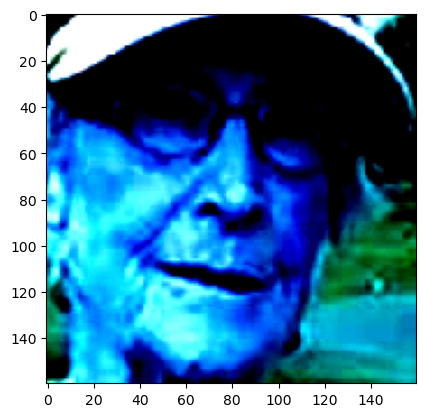

In [27]:
plt.imshow(nn_input_example[0, :])

In [511]:
print(nn_input_example.max(), nn_input_example.min())

2.2635634 -2.3156064


In [512]:
nn_input_example.shape

(1, 160, 160, 3)

# Data generators

In [119]:
target_size

(160, 160)

In [116]:
image_gen = ImageDataGenerator(preprocessing_function=preproc_deepface.preproc_img)

In [95]:
train_generator = image_gen.flow_from_dataframe(
    dataframe=df_train,
    class_mode=CLASS_MODE,
    x_col="filename",
    y_col=target_col,
    directory=img_folder,
    target_size=target_size,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

Found 18957 validated image filenames.


In [96]:
val_generator = image_gen.flow_from_dataframe(
    dataframe=df_val,
    class_mode=CLASS_MODE,
    x_col="filename",
    y_col=target_col,
    directory=img_folder,
    target_size=target_size,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

Found 2370 validated image filenames.


In [516]:
callbacks.extend([loss_plotter_callback, checkpoint])

# Train execute

In [ ]:
EPOCHS = 200

model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks,
    steps_per_epoch=50,
    validation_steps=len(df_val) // BATCH_SIZE,
)

# Score on test

In [38]:
model = load_model("../weights/Facenet_121_age_checkpoint_best.h5")

In [117]:
test_generator = image_gen.flow_from_dataframe(
    dataframe=df_test,
    class_mode=CLASS_MODE,
    x_col="filename",
    y_col=target_col,
    directory=img_folder,
    target_size=target_size,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

Found 2370 validated image filenames.


In [118]:
results = model.evaluate(test_generator, steps=len(df_test) // BATCH_SIZE)

32/32 [==============================] - 3s 96ms/step - loss: 61.5504 - mean_absolute_error: 5.7145


# Example inference

In [134]:
im_orig = load_img(img_path, target_size=target_size)

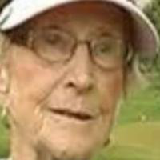

In [135]:
im_orig

In [145]:
age_pred = inference.esteem_age(im_orig, model, preproc_deepface.preproc_img)

age_pred

array([[84.39782]], dtype=float32)

In [147]:
age_pred[0][0]

84.39782

# Store configs for best model

In [137]:
age_dict = {
    "age_best_model_path": cpt_path,
    "age_preproc_family": base_model_name,
    "target_size": list(target_size),
}

In [138]:
with open(yaml_path, "w") as f:
    yaml.dump(
        age_dict,
        f,
        allow_unicode=True,  # makes encoding work properly
        encoding="utf8",
        default_flow_style=False,
    )